## Credits
Steam data - https://store.steampowered.com/search/?category1=998

## Download packages

In [11]:
#pip install selenium

In [148]:
conda install -c conda-forge imbalanced-learn

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\maypo\anaconda3

  added / updated specs:
    - imbalanced-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.12.0               |   py39hcbf5309_0         1.0 MB  conda-forge
    imbalanced-learn-0.7.0     |             py_1          97 KB  conda-forge
    python_abi-3.9             |           2_cp39           4 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         1.1 MB

The following NEW packages will be INSTALLED:

  imbalanced-learn   conda-forge/noarch::imbalanced-learn-0.7.0-py_1
  python_abi         conda-forge/win-64::python_abi-3.9-2_cp39

The following packages will be UPDATED:

  conda              pkgs/main::conda-4.10.3-py39haa95532_0 --> conda-forge::conda-4.12.0-py39hcbf5309_0








==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 4.12.0

Please update conda by running

    $ conda update -n base -c defaults conda





conda-4.12.0         | 1.0 MB    |            |   0% 
conda-4.12.0         | 1.0 MB    | ###8       |  39% 
conda-4.12.0         | 1.0 MB    | #######7   |  77% 
conda-4.12.0         | 1.0 MB    | ########## | 100% 

python_abi-3.9       | 4 KB      |            |   0% 
python_abi-3.9       | 4 KB      | ########## | 100% 
python_abi-3.9       | 4 KB      | ########## | 100% 
Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


## Imports

In [180]:
from time import sleep
from bs4 import BeautifulSoup
from selenium import webdriver
import pandas as pd
import numpy as np
import random
import re
from datetime import datetime
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns

# show several prints in one cell. This will allow us to condence every trick in one cell.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Save and load data from CSV

#### Save to CSV file

In [29]:
def save_to_csv(file_name, dataset):
    dataset.to_csv(file_name)

Save data before cleanup

In [19]:
save_to_csv("all_games_data.csv", df)

Save data after cleanup

In [37]:
save_to_csv("all_games_data_clean.csv", new_df)

#### Load dataset from CSV

In [38]:
def load_csv_from_project(file_name):
    return pd.read_csv(file_name)

Load data before cleanup

In [42]:
df = load_csv_from_project("all_games_data.csv").iloc[:,1:]
df.head()

,title,win_support,mac_support,linux_support,vr_only,vr_supported,relese_date,review,discount,price_discount,price
0,Counter-Strike: Global Offensive,1,1,1,0,0,"21 Aug, 2012","Very Positive<br>88% of the 6,357,070 user rev...",NaN,0.0,0.0
1,Apex Legends™,1,0,0,0,0,"4 Nov, 2020","Very Positive<br>86% of the 436,849 user revie...",NaN,0.0,0.0
2,ELDEN RING,1,0,0,0,0,"24 Feb, 2022","Very Positive<br>89% of the 340,296 user revie...",NaN,249.0,249.0
3,LEGO® Star Wars™: The Skywalker Saga,1,0,0,0,0,"5 Apr, 2022","Very Positive<br>94% of the 15,740 user review...",NaN,199.0,199.0
4,PUBG: BATTLEGROUNDS,1,0,0,0,0,"21 Dec, 2017","Mixed<br>56% of the 2,005,741 user reviews for...",NaN,0.0,0.0


Load data after cleanup

In [353]:
new_df = load_csv_from_project("all_games_data_clean.csv").iloc[:,1:]
new_df.head()

,title,win_support,mac_support,linux_support,vr_only,vr_supported,discount,price_discount,price,overall_review,percentage_positive_total_reviewed,total_reviewed,day,month,year
0,Counter-Strike: Global Offensive,1,1,1,0,0,0,0.0,0.0,Very Positive,88,6357070,21,8,2012
1,Apex Legends™,1,0,0,0,0,0,0.0,0.0,Very Positive,86,436849,4,11,2020
2,ELDEN RING,1,0,0,0,0,0,249.0,249.0,Very Positive,89,340296,24,2,2022
3,LEGO® Star Wars™: The Skywalker Saga,1,0,0,0,0,0,199.0,199.0,Very Positive,94,15740,5,4,2022
4,PUBG: BATTLEGROUNDS,1,0,0,0,0,0,0.0,0.0,Mixed,56,2005741,21,12,2017


## Helper Functions

In [3]:
def write_soup_to_file(file_name : str, soup : BeautifulSoup):
    with open(file_name, "w", encoding='utf-8') as file:
        file.write(str(soup))

In [4]:
def load_soup_object(html_file_name : str):
    with open(html_file_name, "r", encoding='utf8') as file:
        soup = BeautifulSoup(file, "html.parser")
    return soup

In [13]:
def isfloat(num):
    try:
        float(num)
        return True
    except ValueError:
        return False

In [14]:
def isint(num):
    try:
        int(num)
        return True
    except ValueError:
        return False

## Crawling With Selenium & BeautifulSoup

In [2]:
def get_driver_Firefox():
    return webdriver.Firefox()  

In [3]:
def infinite_scroll(driver : webdriver.firefox.webdriver.WebDriver):
    
    _isScrolling = True
    SCROLL_PAUSE_TIME = 0.8
    
    # Get scroll height
    last_height = driver.execute_script("return document.body.scrollHeight")
    
    while _isScrolling:
                
        # Scroll down to bottom
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    
        # Wait to load page
        sleep(SCROLL_PAUSE_TIME)
        SCROLL_PAUSE_TIME = random.uniform(0.8,3)
        
        # Calculate new scroll height and compare with last scroll height
        new_height = driver.execute_script("return document.body.scrollHeight")
                
        if new_height == last_height:
            #Another check
            sleep(20)
            new_height = driver.execute_script("return document.body.scrollHeight")
            
            if new_height == last_height:            
                _isScrolling = False
                                
        last_height = new_height

In [35]:
def selenium_scrapping():
    url = "https://store.steampowered.com/search/?category1=998"
    driver = get_driver_Firefox()
    
    driver.get(url)
    driver.maximize_window()
    
    # Wait for the page to fully render before parsing it
    sleep(5)
    
    infinite_scroll(driver)
    
    print("Finish scroling... initialize BeautifulSoup")
    
    soup = BeautifulSoup(driver.page_source, "html.parser")
    
    #quits the driver instance, closing every associated window, which is opened.
    driver.quit()
    
#selenium_scrapping()

In [ ]:
#Saved soup for easier access.
#write_soup_to_file("All_Games.html", soup)

### Load BeautifulSoup

In [5]:
soup = load_soup_object("All_Games.html")

## Data Acquisition

In [7]:
def game_tag_exist(game , tag : str, classTag : str):
    if game.find(tag, attrs={"class",classTag}):
        return 1
    return 0

In [8]:
def game_get_text_tag(game, tag :str , classTag : str):
    return game.find(tag, attrs={"class", classTag}).get_text().strip()

In [9]:
def game_val_tag(game, tag :str , classTag : str):
    if game_tag_exist(game, tag, classTag):
        val = game_get_text_tag(game, tag, classTag)
        return np.nan if val == '' else val
        
    return np.nan

In [10]:
def game_prices(game, tag :str , classTag : str):
    prices = [np.nan]
    price_text = game_val_tag(game, "div", "search_price")
    if price_text is not np.nan:        
        if '₪' in price_text:
            prices = price_text.split('₪')
            prices.pop(0)
            if isfloat(prices[0]) is False:
                # price with ',' like 1,850.00
                if ',' in prices[0] :
                    prices[0] = float(prices[0].replace(',', ''))
                #Price like 49.00Free and discount 70% - is not relevent (only 2 like this)
                else:
                    prices = [np.nan]
            else:
                prices = [float(i) for i in prices]
        else:
            #free games
            prices = [float(0)]
            
    return prices
        

In [11]:
def scrape_games(soup : BeautifulSoup):
    game_title = list()
    game_win_support = list()
    game_mac_support = list()
    game_linux_support = list()    
    game_vr_only = list()
    game_vr_supported = list()
    game_relese_date = list()
    game_review = list()
    game_discount = list()
    game_price_discount = list()
    game_price = list()    
    
    all_games = soup("a",attrs={"class":"search_result_row"})    
    for game in all_games:
        game_title.append(game_val_tag(game, 'span', 'title'))
        game_win_support.append(game_tag_exist(game,'span', "win"))
        game_mac_support.append(game_tag_exist(game,'span', "mac"))
        game_linux_support.append(game_tag_exist(game,'span', "linux"))
        game_vr_only.append(game_tag_exist(game,'span', "vr_required"))
        game_vr_supported.append(game_tag_exist(game,'span', "vr_supported"))
        game_relese_date.append(game_val_tag(game, "div", "search_released"))
        game_review.append(game.find("span", attrs={"class",'search_review_summary'})['data-tooltip-html'] if game_tag_exist(game,'span', "search_review_summary") else np.nan)
        game_discount.append(game_val_tag(game, "div", "search_discount"))
        
        prices = game_prices(game, "div", "search_price")       
        game_price.append(prices[0])
        game_price_discount.append(prices[0] if len(prices) == 1 else prices[1])
         
    return pd.DataFrame({"title":game_title, "win_support":game_win_support
                         , "mac_support":game_mac_support, "linux_support":game_linux_support,
                         "vr_only":game_vr_only, "vr_supported":game_vr_supported,
                           "relese_date": game_relese_date, "review":game_review,
                         "discount":game_discount , "price_discount":game_price_discount ,"price":game_price })

In [15]:
df = scrape_games(soup)

## Handle Missing Values

In [35]:
#drop rows with missing price, release date and titles
df.dropna(subset=['price','relese_date','title'], inplace=True)
#no discount menas 0
df.discount.fillna(0, inplace=True)

## Data Cleaning

#### discount

In [31]:
def discount_clean(df : pd.DataFrame):
    df_copy = df.copy()
    df_copy['discount'] = [int(re.sub("[-%]" ,"", str(discount))) for discount in df_copy['discount']]
    return df_copy

#### review

In [32]:
def review_clean(df : pd.DataFrame):
    df_copy = df.copy()
    
    overall_review = list()
    percentage_positive_total_reviewed = list()
    total_reviewed = list()
    
    for rev in df_copy['review']:
        #For removing if else
        splited_data = ['no reviews','0 0 0 0']
        if rev is not np.nan:
            splited_data = rev.split('<br>')    
                
        reviewers = splited_data[1].split(' ')            
        overall_review.append(splited_data[0])        
        percentage_positive_total_reviewed.append(int(reviewers[0].replace('%','')))
        total_reviewed.append(int(reviewers[3].replace(',','')))
        
    df_copy['overall_review'] = overall_review
    df_copy['percentage_positive_total_reviewed'] = percentage_positive_total_reviewed
    df_copy['total_reviewed'] = total_reviewed
    
    df_copy.drop(['review'], axis = 1, inplace=True)
    
    return df_copy

#### relese_date

In [33]:
def relese_date_clean(df : pd.DataFrame):
    df_copy = df.copy()
    
    day = list()
    month = list()
    year = list()
    rows_to_remove = list()
    
    for idx in df_copy.relese_date.index.values:
        date_splited = df_copy.relese_date[idx].split(' ') 
        if len(date_splited) == 3 and isint(date_splited[0]):
            final_date = datetime.strptime(df_copy.relese_date[idx].replace(',',''), '%d %b %Y').strftime('%d %m %Y')
            date_splited = final_date.split(' ')
            day.append(date_splited[0])
            month.append(date_splited[1])
            year.append(date_splited[2])
        else:
            rows_to_remove.append(idx)
            
    df_copy.drop(index=rows_to_remove, inplace=True)
    df_copy.drop(['relese_date'], axis = 1, inplace=True)
    df_copy['day'] = day
    df_copy['month'] = month
    df_copy['year'] = year
    
    return df_copy

#### Cleaning Data

In [262]:
new_df = discount_clean(df)
new_df = review_clean(new_df)
new_df = relese_date_clean(new_df)

ValueError: invalid literal for int() with base 10: 'nan'

# Data Handeling

#### outliers

#### Handle Text values
We would like to transform the categorial data to unique numeric data

In [68]:
def factorize_column(col_name, dataset):
    return pd.factorize(dataset[col_name], sort=True)[0]

##### Title & Overall revirew - factorize

In [264]:
num_dataset = new_df.copy()
num_dataset['title'] = factorize_column('title', num_dataset)
num_dataset['overall_review'] = factorize_column('overall_review', num_dataset)
num_dataset

,title,win_support,mac_support,linux_support,vr_only,vr_supported,discount,price_discount,price,overall_review,percentage_positive_total_reviewed,total_reviewed,day,month,year
0,8406,1,1,1,0,0,0,0.00,0.00,8,88,6357070,21,8,2012
1,2468,1,0,0,0,0,0,0.00,0.00,8,86,436849,4,11,2020
2,12251,1,0,0,0,0,0,249.00,249.00,8,89,340296,24,2,2022
3,21356,1,0,0,0,0,0,199.00,199.00,8,94,15740,5,4,2022
4,27942,1,0,0,0,0,0,0.00,0.00,0,56,2005741,21,12,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51440,15954,1,0,0,0,0,0,0.00,0.00,9,0,0,11,4,2020
51441,38934,1,0,0,0,0,0,10.95,10.95,9,0,0,4,11,2019
51442,20383,1,0,0,0,0,0,0.00,0.00,9,0,0,15,12,2020
51443,28898,1,0,0,0,0,0,18.50,18.50,9,0,0,16,3,2021


### Test on Data - Temporary

In [649]:
new_df[new_df["overall_review"] == "no reviews"]

,title,win_support,mac_support,linux_support,vr_only,vr_supported,discount,price_discount,price,overall_review,percentage_positive_total_reviewed,total_reviewed,day,month,year
227,EA Play,1,0,0,0,0,0,22.50,22.50,no reviews,0,0,31,08,2020
466,"Warhammer 40,000: Chaos Gate - Daemonhunters",1,0,0,0,0,0,169.95,169.95,no reviews,0,0,05,05,2022
569,The Elder Scrolls Online: High Isle,1,1,0,0,0,0,159.00,159.00,no reviews,0,0,06,06,2022
1630,S.T.A.L.K.E.R. 2: Heart of Chornobyl,1,0,0,0,0,0,239.00,239.00,no reviews,0,0,08,12,2022
2797,Forspoken,1,0,0,0,0,0,319.00,319.00,no reviews,0,0,11,10,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64200,Gator Parade,1,0,0,0,0,0,0.00,0.00,no reviews,0,0,11,04,2020
64202,The Delirium Vacation,1,0,0,0,0,0,10.95,10.95,no reviews,0,0,04,11,2019
64204,Juicy Army: Prologue,1,0,0,0,0,0,0.00,0.00,no reviews,0,0,15,12,2020
64205,Pixels can fight,1,0,0,0,0,0,18.50,18.50,no reviews,0,0,16,03,2021


In [63]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51445 entries, 0 to 51444
Data columns (total 15 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   title                               51445 non-null  object 
 1   win_support                         51445 non-null  int64  
 2   mac_support                         51445 non-null  int64  
 3   linux_support                       51445 non-null  int64  
 4   vr_only                             51445 non-null  int64  
 5   vr_supported                        51445 non-null  int64  
 6   discount                            51445 non-null  int64  
 7   price_discount                      51445 non-null  float64
 8   price                               51445 non-null  float64
 9   overall_review                      51445 non-null  object 
 10  percentage_positive_total_reviewed  51445 non-null  int64  
 11  total_reviewed                      51445

In [651]:
comparison_column = np.where(new_df.price < new_df.price_discount, True, False)
print(comparison_column.any())

False


In [652]:
new_df.isnull().sum()

title                                 0
win_support                           0
mac_support                           0
linux_support                         0
vr_only                               0
vr_supported                          0
discount                              0
price_discount                        0
price                                 0
overall_review                        0
percentage_positive_total_reviewed    0
total_reviewed                        0
day                                   0
month                                 0
year                                  0
dtype: int64

In [451]:
all_games = soup.find_all("a", {"class": "search_result_row"})
all_games

[<a class="search_result_row ds_collapse_flag app_impression_tracked" data-ds-appid="730" data-ds-crtrids="[4]" data-ds-descids="[2,5]" data-ds-itemkey="App_730" data-ds-steam-deck-compat-handled="true" data-ds-tagids="[1663,1774,3859,3878,19,5711,5055]" data-gpnav="item" href="https://store.steampowered.com/app/730/CounterStrike_Global_Offensive/?snr=1_7_7_230_150_1" onmouseout="HideGameHover( this, event, 'global_hover' )" onmouseover="GameHover( this, event, 'global_hover', {&quot;type&quot;:&quot;app&quot;,&quot;id&quot;:730,&quot;public&quot;:1,&quot;v6&quot;:1} );">
 <div class="col search_capsule"><img src="https://cdn.akamai.steamstatic.com/steam/apps/730/capsule_sm_120.jpg?t=1641233427" srcset="https://cdn.akamai.steamstatic.com/steam/apps/730/capsule_sm_120.jpg?t=1641233427 1x, https://cdn.akamai.steamstatic.com/steam/apps/730/capsule_231x87.jpg?t=1641233427 2x"/></div>
 <div class="responsive_search_name_combined">
 <div class="col search_name ellipsis">
 <span class="title"

In [43]:
len(all_games)

NameError: name 'all_games' is not defined

# EDA

#### Helper functions

get_frequenft_elements returns the value count of the elements in the received column name

In [129]:
def get_frequenft_elements(df, col_name):
    return df[col_name].value_counts().sort_index()

amount_of_discounts will provide as a series with the amount of games with a discount and the amount of games without.

In [133]:
def amount_of_discounts(df):
    no_discound_sum = (df['discount'] == 0).sum()    
    with_discound_sum = (df['discount'] != 0).sum()

    return pd.Series(data={'no discount': no_discound_sum, 'has discount': with_discound_sum})

In [137]:
def add_has_discount_col(df):
    
    edited_df = df.copy()
    has_discount = list()
    
    for idx in edited_df.discount.index.values:
        if edited_df.discount[idx] != 0:
            has_discount.append(1)
        else:
            has_discount.append(0)
    
    edited_df['has_discount'] = has_discount
    
    return edited_df

#### Deep investigation

We would like to get a dipper understanding about our data.

First, we will check if our data is balanced. 
We would like to make sure that we have a wide and balanced cut in the game types.

We would like to axamin: 
1. overall_review
2. release year
3. Amount of games With and without discount
4. Price

#### 1. overall_review

In [275]:
def pie_chart_overall_review(df, fig, axes, title, show_data):

    sr_freq_directors = get_frequenft_elements(new_df, 'overall_review')
    
    if show_data:
        print (sr_freq_directors)

    mylabels = ["Overwhelmingly Positive", "Very Positive", "Positive", "Mostly Positive", "Mixed", "Mostly Negative", "Negative", "Very Negative", "Overwhelmingly Negative", "no reviews"]
    mycolors = ["#0ae000",                 "#8dec48",       "#aefc50",  "#c1fe1f",        "#f5fc0f", "#fcd40f",        "#fca60f",  "#fc6c0f",       "#fc0f0f",                 "#a4dcd5"]

    sr_freq_directors.plot(kind='pie', ax=axes, title=title, ylabel="review")
    #sr_freq_directors.plot(kind='pie', ax=axes, labels = mylabels, colors = mycolors)

Mixed                       7749
Mostly Negative             1088
Mostly Positive             5536
Negative                     173
Overwhelmingly Negative        6
Overwhelmingly Positive      853
Positive                    6657
Very Negative                 25
Very Positive               9046
no reviews                 20312
Name: overall_review, dtype: int64


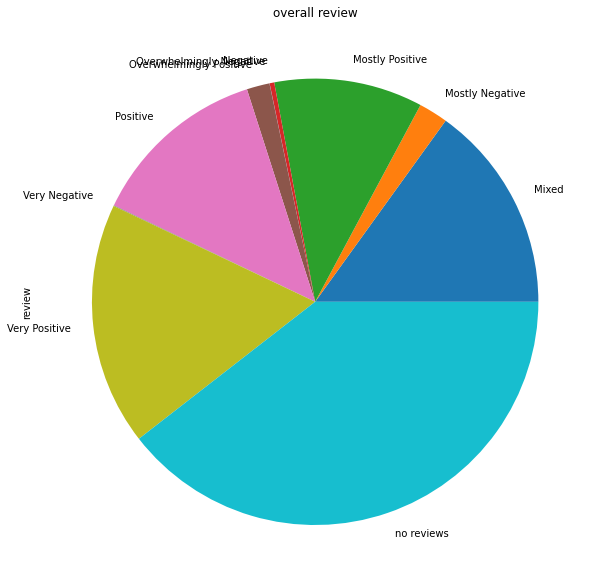

In [354]:
fig, axes = plt.subplots(1,1, figsize=(10, 40))

pie_chart_overall_review(new_df, fig, axes, "overall review", True)

According to Steam review rating system - The classification by positive precantage:

    95 - 99% : Overhwelmingly Positive
    94 - 80% : Very Positive
    80 - 99% + few reviews: Positive
    70 - 79% : Mostly Positive
    40 - 69% : Mixed
    20 - 39% : Mostly Negative
    0 - 39% + rew reviews: Negative
    0 - 19% : Very Negative
    0 - 19% + many reviews: Overwhelmingly Negative
    
Most of our games are rated as positive and higher as expected form a Games store like Steam.

#### 2. Release year

In [355]:
def pie_chart_release_year_investigation(df, fig, axes, title, show_data):

    sr_freq_directors = get_frequenft_elements(df, 'year')
    
    if show_data:
        print (title)
        print (sr_freq_directors)

    sr_freq_directors.plot(kind='pie', ax=axes, ylabel="year", title=title)

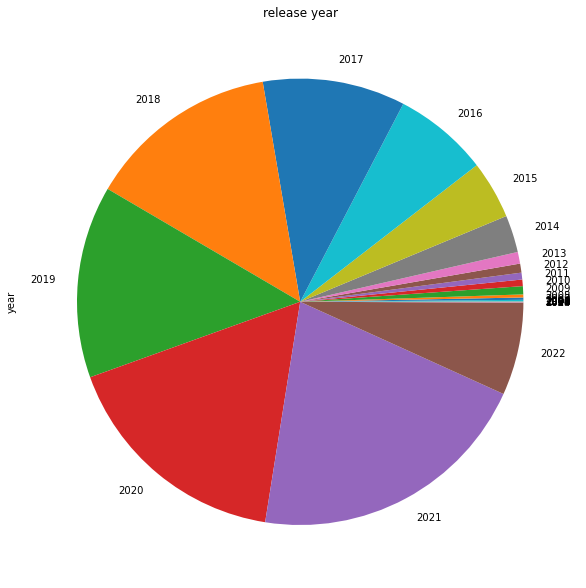

In [356]:
fig, axes = plt.subplots(1,1, figsize=(10, 40))

pie_chart_release_year_investigation(new_df, fig, axes, "release year", False)

We were positivly impressed by this graph. It shows a pretty big variaty of release years.
Its predicted that most of the games offered for sale will be from the last few years but we were impressed that there is a generouse amount of games from over 4 years ago.

But, we also noticed some outliers we should handle.
Release date shouln't be above 2022 since we are in 2022 and we would like to igonre data from 2005 and below since it is might not be relevant anymore.

##### Remove outliers

C:\Users\maypo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='year'>

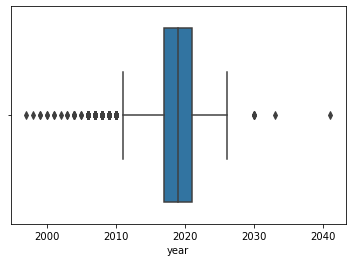

In [357]:
sns.boxplot(new_df.year)

In [358]:
def drop_year_outliers(df, min_year):
    df_centered = df.drop(df[df.year > 2022].index).copy()
    df_centered = df_centered.drop(df_centered[df_centered.year <= min_year].index) 
    return df_centered

C:\Users\maypo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='year'>

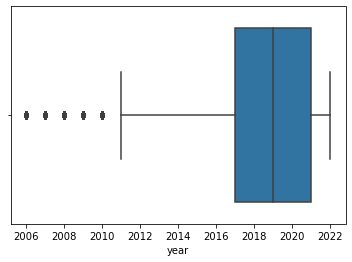

In [359]:
df_no_outliers = drop_year_outliers(new_df, 2005)

sns.boxplot(df_no_outliers.year)

Better. Now after we don't have outliers, we can re-investigate the release year data.

Let's try to drop rows from 2013 and below.

C:\Users\maypo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='year'>

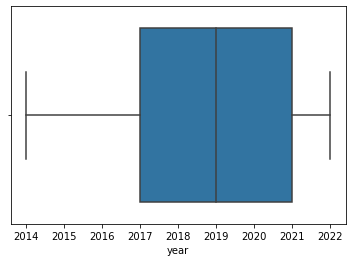

In [360]:
df_no_outliers = drop_year_outliers(new_df, 2013)

sns.boxplot(df_no_outliers.year)

Looks like there aren't any outliers.
Let's compare the changes:

include outliers
1997        1
1998        1
1999        2
2000        2
2001        2
2002        1
2003        2
2004        6
2005        2
2006       54
2007       86
2008      113
2009      304
2010      244
2011      254
2012      336
2013      435
2014     1383
2015     2164
2016     3538
2017     5314
2018     7138
2019     7165
2020     8745
2021    10668
2022     3455
2023       15
2024        6
2026        3
2030        4
2033        1
2041        1
Name: year, dtype: int64
---
without outliers
2014     1383
2015     2164
2016     3538
2017     5314
2018     7138
2019     7165
2020     8745
2021    10668
2022     3455
Name: year, dtype: int64


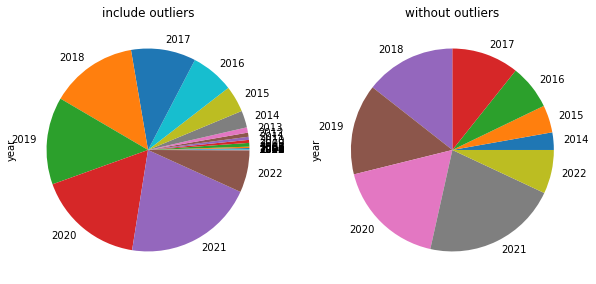

In [361]:
fig, axes = plt.subplots(1,2, figsize=(10, 40))

pie_chart_release_year_investigation(new_df, fig, axes[0], "include outliers", True)
print("---")
pie_chart_release_year_investigation(df_no_outliers, fig, axes[1], "without outliers", True)

Looks like our data is much cleaner now

In [363]:
new_df = df_no_outliers

#### 3. Amount of games with and without discount

First, we will create a new column that will indecates whether the game is on sale or not.

In [365]:
def pie_chart_discount_investigation(df, fig, axes, title, show_data):

    sr_freq_directors = amount_of_discounts(df)
    
    if show_data:
        print (title)
        print (sr_freq_directors)

    sr_freq_directors.plot(kind='pie', ax=axes, ylabel="discount", title=title)

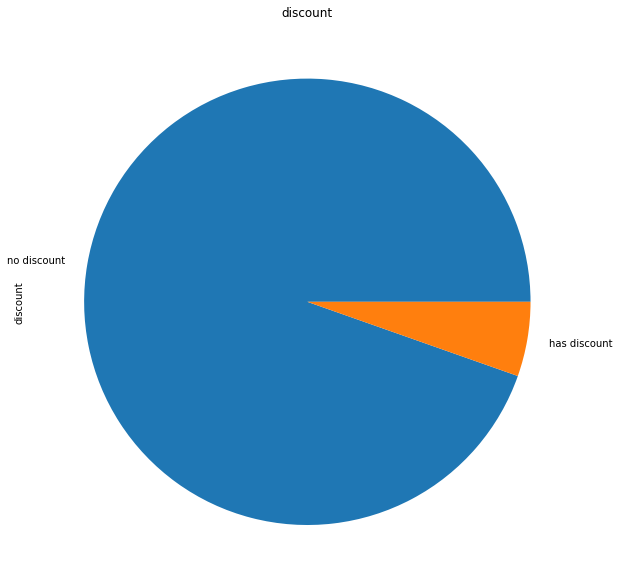

In [366]:
fig, axes = plt.subplots(1,1, figsize=(10, 40))

pie_chart_discount_investigation(new_df, fig, axes, "discount", False)

After analyzing this graph we can understand that our data needs a bit more balanced.
The amount of data for games without discount is much higher then the amount of games with discount.
We will have to adjust our data and balance it by duplicating the games data with discount and present Oversampling.

##### Oversampling
Randomly duplicate examples in the minority class

In [367]:
def preform_oversampling_has_discount(df):
    
    edited_df = add_has_discount_col(df)
    
    oversample = RandomOverSampler(sampling_strategy=0.5)
    oversample_df, oversample_has_discount = oversample.fit_resample(edited_df, edited_df['has_discount'])
    
    return oversample_df

In [368]:
oversample_df = preform_oversampling_has_discount(new_df)

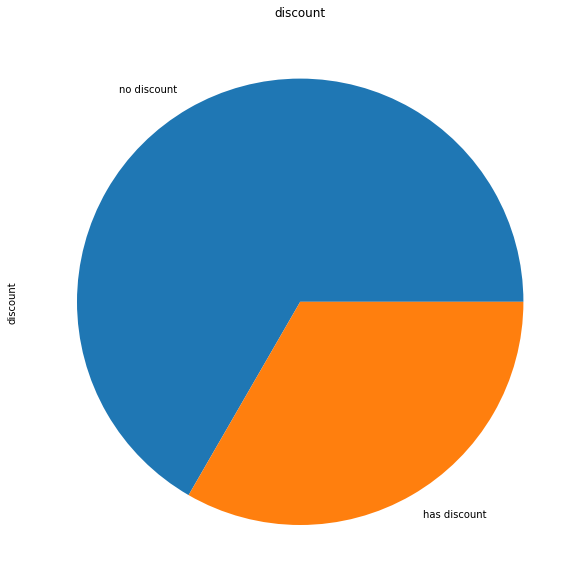

In [369]:
fig, axes = plt.subplots(1,1, figsize=(10, 40))

pie_chart_discount_investigation(oversample_df, fig, axes, "discount", False)

Looks much better. Seems like our data is balanced now

By comparing both pie charts before and after oversampling we can witness the improvment:

before oversampling
no discount     46896
has discount     2674
dtype: int64
after oversampling
no discount     46896
has discount    23448
dtype: int64


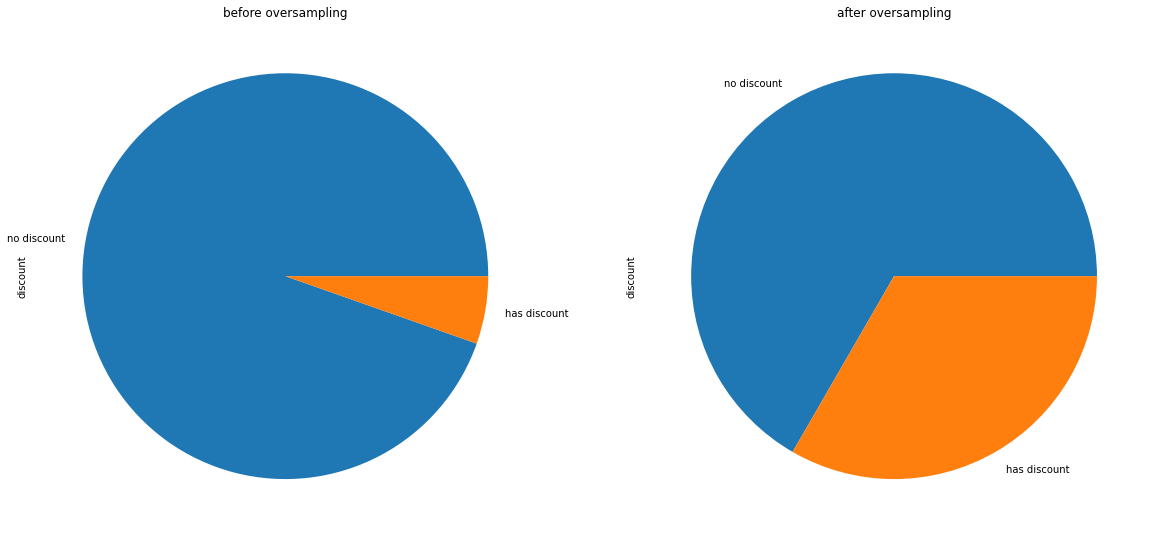

In [371]:
fig, axes = plt.subplots(1,2, figsize=(20, 30))

pie_chart_discount_investigation(new_df, fig, axes[0], "before oversampling", True)
pie_chart_discount_investigation(oversample_df, fig, axes[1], "after oversampling", True)

In [372]:
# update our dataset with the balanced data
new_df = oversample_df

#### 4. Price

In [373]:
def pie_chart_price_investigation(df, fig, axes, title, show_data):

    sr_freq_directors = get_frequenft_elements(df, 'price')
    
    if show_data:
        print (title)
        print (sr_freq_directors)

    sr_freq_directors.plot(kind='pie', ax=axes, ylabel="price", title=title)

overall review
0.00       6685
3.15         22
3.16          1
3.20         12
3.24          1
           ... 
449.95        3
564.95        1
749.95       22
1450.00       1
1850.00       1
Name: price, Length: 554, dtype: int64


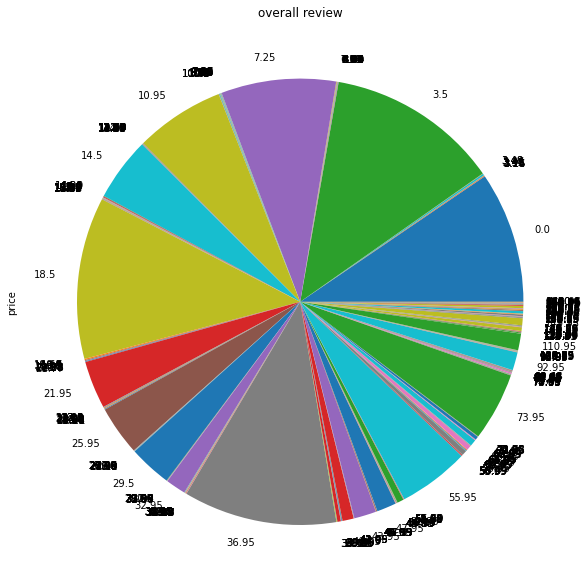

In [374]:
fig, axes = plt.subplots(1,1, figsize=(10, 40))

pie_chart_price_investigation(new_df, fig, axes, "overall review", True)

Let's check if we have any outliers:

C:\Users\maypo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price'>

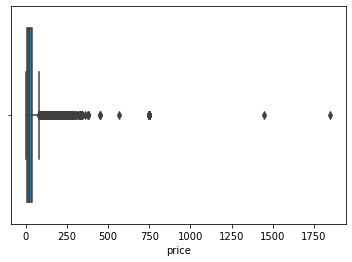

In [375]:
sns.boxplot(new_df.price)

##### Remove outliers

In [379]:
def drop_price_outliers(df, max_price):
    df_centered = df.drop(df[df.price > max_price].index).copy()
    return df_centered

C:\Users\maypo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price'>

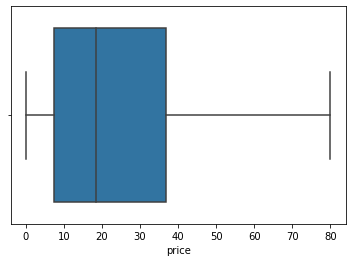

In [382]:
df_no_price_outliers = drop_price_outliers(new_df, 80)

sns.boxplot(df_no_price_outliers.price)

Now we no longer has outliers in our price column.

Price with outlier
0.00       6685
3.15         22
3.16          1
3.20         12
3.24          1
           ... 
449.95        3
564.95        1
749.95       22
1450.00       1
1850.00       1
Name: price, Length: 554, dtype: int64
Price without outlier
0.00     6685
3.15       22
3.16        1
3.20       12
3.24        1
         ... 
78.95       1
79.00      79
79.95      29
79.99       3
80.00       4
Name: price, Length: 360, dtype: int64


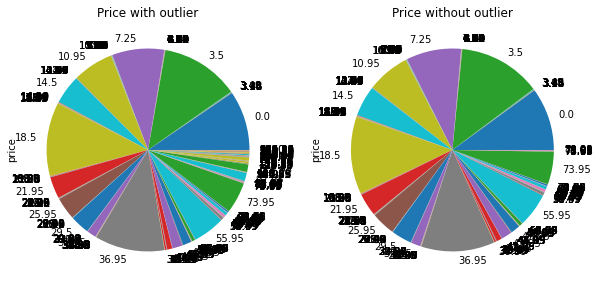

In [383]:
fig, axes = plt.subplots(1,2, figsize=(10, 40))

pie_chart_price_investigation(new_df, fig, axes[0], "Price with outlier", True)
pie_chart_price_investigation(df_no_price_outliers, fig, axes[1], "Price without outlier", True)

In [385]:
# update our dataset with the balanced data
new_df = df_no_price_outliers

Now we can see clearly that our data is balanced and ready for investigation

In [309]:
def drop_support_column(df, col_name):
    return df.drop(col_name, axis = 1).copy()

In [329]:
# we are no long need the has_discount column we can remove it
# new_df = drop_support_column(oversample_df, "has_discount")

We've finished our data handling, we handled outliers and unbalanced data.

Final results:

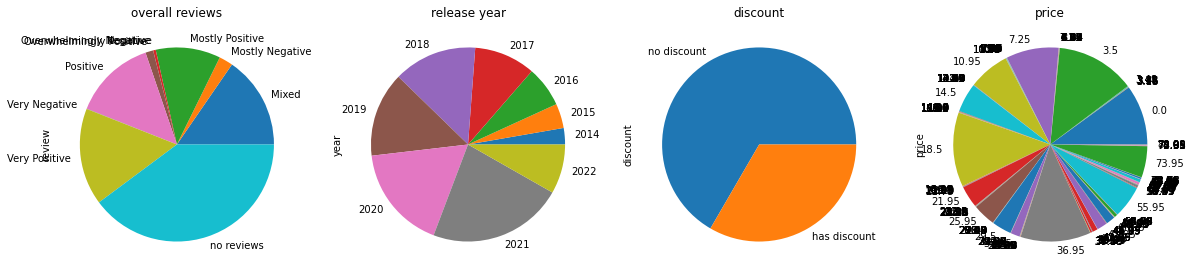

In [391]:
fig, axes = plt.subplots(1,4, figsize=(20, 30))

pie_chart_overall_review(new_df, fig, axes[0], "overall reviews", False)
pie_chart_release_year_investigation(new_df, fig, axes[1], "release year", False)
pie_chart_discount_investigation(new_df, fig, axes[2], "discount", False)
pie_chart_price_investigation(new_df, fig, axes[3], "price", False)

Let's check what is our state. We lost and added data during the deep investigation.

In [392]:
print(new_df.shape)

(66763, 16)


### Correlation

We want to perform Cross tabulation in order to find a connection between two different parameters

##### Helper functions

cross_tabulation function is a function to create and return a datadrame of a cross tabulation between the given 'col_name' column and the given 'other_col_name' column

In [393]:
def cross_tabulation(df, col_name, other_col_name):
    ###
    ### YOUR CODE HERE
    ###
    return pd.crosstab(df[col_name], df[other_col_name], normalize="index")

'plot_cross_tabulation' function to create a cross tabulation for each of the columns in the given 'col_names' with the other given 'other_col_name' column.
The function plot a 'line' plot for each dataframe of the cross tabulation.

In [398]:
def plot_cross_tabulation(df, col_names, other_col_name):
    ###
    ### YOUR CODE HERE
    ###
    fig, axes = plt.subplots(1,len(col_names), figsize=(20,5))
    i = 0
    for col in col_names:
        crosstb = cross_tabulation(df, col, other_col_name)
        crosstb.plot(kind="line", ax=axes[i])
        i = i + 1

'get_highly_correlated_cols' function to return two arrays:
* 'correlations'
    - An python list, containing the correlation values for highly correlated columns from the given 'df' dataframe.
* 'tuple_arr'  
    - A python list, containing two dimensional tuples, representing two columns with a high correlation.
        * Two columns are considered as correlated if the value of the Pearson correlation coefficient of these columns is >=0.5. 
        * Each tuple should look like this: (i, j), where 'i' and 'j' are number of the highly correlated columns.
        * Remember that for two columns x, y, the correlation(x,y) =  correlation(y,x).
        * Only one corresponding pair should be returned. 
        * You should make sure that i < j. For instance, if columns 3 and 5 are correlated, return the tuple (3, 5) instead of (5, 3).
        * Don't forget to filter self correlation (of a column with the same column).

In [399]:
def get_highly_correlated_cols(df):
    ###
    ### YOUR CODE HERE
    ###
    tuple_arr = []
    correlations = []
    for col1 in df.columns:
        for col2 in df.columns:
            col1_index = df.columns.get_loc(col1)
            col2_index = df.columns.get_loc(col2)
            if col1_index < col2_index:
                corr = df[col1].corr(df[col2], method='pearson')
                if corr >= 0.5:
                    print (corr)
                    tup = (col1_index, col2_index)
                    tuple_arr.append(tup)
                    correlations.append(corr)
    
    return correlations, tuple_arr

'plot_high_correlated_scatters' function to plot scatter plots for each column pair, of the given 'df' dataframe, which has a high Pearson correlation coefficient (>=0.5). 
Uses the 'get_highly_correlated_cols', which you've already implemented, to get the highly correlated column pair numbers.

In [400]:
def plot_high_correlated_scatters(df):
    ###
    ### YOUR CODE HERE
    ###
    
    i = 0
    correlations, tuple_arr = get_highly_correlated_cols(df)
    fig, axes = plt.subplots(1,len(correlations), figsize=(20,5))
    for pair in tuple_arr:
        col_name_lt, col_name_rt = df.columns[pair[0]], df.columns[pair[1]]
        title = "corr('%s', '%s')=%4.2f" %(col_name_lt, col_name_rt, correlations[i]) 
        df.plot(col_name_lt, col_name_rt, kind="scatter", ax=axes[i], title = title)
        i = i + 1

#### Is there a connection between the release year and overall review with the discount precentage?

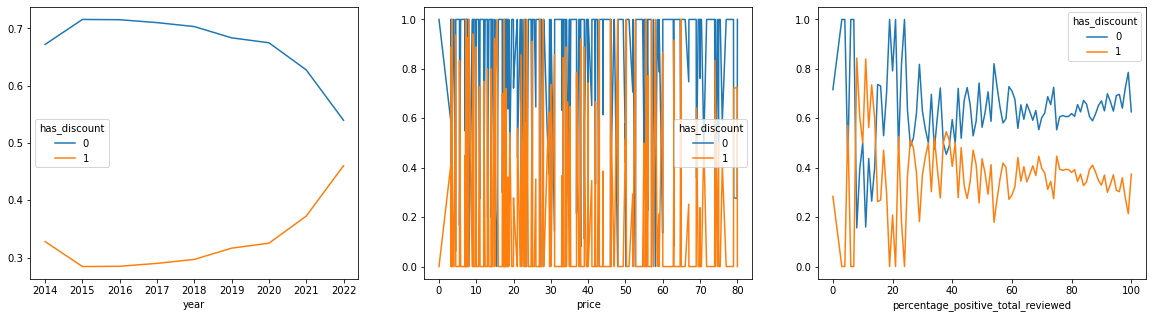

In [396]:
plot_cross_tabulation(new_df, ['year','price','percentage_positive_total_reviewed'], 'has_discount')

By investigating these graphs we can understand that there is a connection between the release year and if the game is on sale or not and also between the precentage of positve reviews.

The newer the game the possiblity for it to be on sale is higher and if it's positive reviews precentage is around 5% - 15%

We've learned about the affects of release year and positive reviews of whether the game is on sale or not. Let's investigate the correlation between those parameters with the precantage of the discount.

In [410]:
new_df.groupby('year').has_discount.mean()
new_df.groupby('has_discount').year.mean()
new_df.groupby('has_discount').percentage_positive_total_reviewed.mean()
new_df.groupby('percentage_positive_total_reviewed').has_discount.mean()

print("=-----")
new_df.groupby('year').discount.mean()
new_df.groupby('percentage_positive_total_reviewed').discount.mean()

year
2014    0.327851
2015    0.284249
2016    0.284705
2017    0.289783
2018    0.296695
2019    0.316364
2020    0.324976
2021    0.372283
2022    0.460335
Name: has_discount, dtype: float64

has_discount
0    2018.904301
1    2019.264632
Name: year, dtype: float64

has_discount
0    43.812917
1    49.850718
Name: percentage_positive_total_reviewed, dtype: float64

percentage_positive_total_reviewed
0      0.284017
3      0.000000
4      0.000000
5      0.571429
6      0.000000
         ...   
96     0.303062
97     0.359084
98     0.277008
99     0.214286
100    0.373693
Name: has_discount, Length: 99, dtype: float64

=-----


year
2014    23.594298
2015    19.922711
2016    18.569190
2017    18.131679
2018    18.173539
2019    17.989713
2020    17.222452
2021    18.747491
2022    16.178675
Name: discount, dtype: float64

percentage_positive_total_reviewed
0      15.313945
3       0.000000
4       0.000000
5      45.714286
6       0.000000
         ...    
96     13.115100
97     14.123033
98      9.047091
99      8.571429
100    16.320122
Name: discount, Length: 99, dtype: float64

<AxesSubplot:xlabel='year'>

Text(0, 0.5, 'Discount precentage')

Text(0.5, 1.0, 'Correlation between release year and the discount precentage')

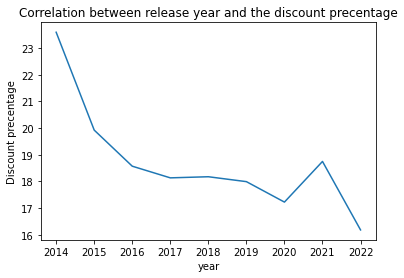

In [416]:
new_df.groupby('year').discount.mean().plot(kind='line')  #kind=line is used in order to obtain a line plot\n",
plt.ylabel('Discount precentage')
plt.title("Correlation between release year and the discount precentage")

<AxesSubplot:xlabel='percentage_positive_total_reviewed'>

Text(0, 0.5, 'Discount precentage')

Text(0.5, 1.0, 'Correlation between positive reviews and the discount precentage')

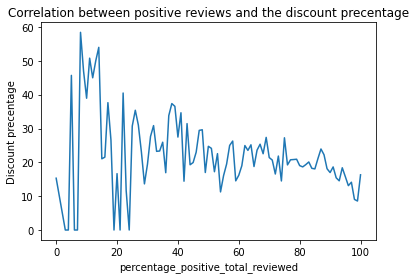

In [417]:
new_df.groupby('percentage_positive_total_reviewed').discount.mean().plot(kind='line')  #kind=line is used in order to obtain a line plot\n",
plt.ylabel('Discount precentage')
plt.title("Correlation between positive reviews and the discount precentage")

In [402]:
plot_high_correlated_scatters(new_df)

TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [418]:
correlations, tuple_arr = get_highly_correlated_cols(df)

TypeError: unsupported operand type(s) for /: 'str' and 'int'